In [ ]:
# using Pkg; Pkg.activate(".")
# push!(LOAD_PATH, pwd()*"/..") ## DrWatson projects take care of this Pkg/dev functionality
# Pkg.status()

In [1]:
using DrWatson
@quickactivate "CSegKgJ"

  Activating environment at `~/projects/CSegKgJ/Project.toml`


In [ ]:
using CSegKgJ # helper functions for this project

# Data

In [ ]:
using CSV, DataFrames
df_train = CSV.read(Config.data_path * "train.csv", DataFrame);


In [ ]:
CSegKgJ.gen_masks(df_train)

In [ ]:
DataFrames.names(df_train)

In [ ]:
classes = DataFrames.unique(df_train[!, :cell_type])

In [ ]:

# Each mask contains only 1 cell type
for i in DataFrames.unique(df_train[!, :id])
    if 1 < length(DataFrames.unique(DataFrames.filter(:id => ==(i), df_train)[:, :cell_type]))
        println(i)
    end
end

In [ ]:
for i = 1:DataFrames.ncol(df_test)
    a = DataFrames.nrow(df_test) - sum(DataFrames.completecases(df_test, [i]))
    name = DataFrames.names(df_test, [i])
    println("$i: $name is missing $a")
end

In [ ]:
CSegKgJ.decode_rle(df_train[3,2])[173567]

In [2]:
using FastAI, Metalhead
using Wandb, FluxTraining, Logging
import CairoMakie; CairoMakie.activate!(type="png")

┌ Info: Using Wandb version 0.12.6
└ @ Wandb /home/justin/.julia/packages/Wandb/Xi4iY/src/Wandb.jl:9
┌ Warning: Package Wandb does not have FluxTraining in its dependencies:
│ - If you have Wandb checked out for development and have
│   added FluxTraining as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Wandb
│ Loading FluxTraining into Wandb from project dependency, future warnings for Wandb are suppressed.
└ @ nothing nothing:910


In [ ]:
# Wandb
backend = WandbBackend(project = "CSegKgJ1", name = nothing)

In [ ]:
metricscb = LogMetrics(backend)
hparamscb = LogHyperParams(backend)

In [10]:
dir = "../data"
classes = ["background", "cell"]
# classes = DataFrames.unique(df_train[!, :cell_type])
images = Datasets.loadfolderdata(
    joinpath(dir, "train"),
    filterfn=isimagefile,
    loadfn=loadfile)

masks = Datasets.loadfolderdata(
    joinpath(dir, "masks"),
    filterfn=isimagefile,
    loadfn=f -> loadmask(f, classes))

data = (images, masks)


(mapobs(loadfile, ["../data/train/0030fd0e6378.png", "../data/train/0140b3c8f445.png", "../data/tr…]), mapobs(#1, ["../data/masks/0030fd0e6378.png", "../data/masks/0140b3c8f445.png", "../data/ma…]))

In [82]:
image, mask = sample = getobs(data, 1);
# mask

In [6]:
size.(sample), eltype.(sample)

(((520, 704), (520, 704)), (ColorTypes.Gray{FixedPointNumbers.N0f8}, String))

In [26]:
view(mask, 50:55, 50:55)

SubArray{ColorTypes.Gray{FixedPointNumbers.N0f8}, 2, PermutedDimsArray{ColorTypes.Gray{FixedPointNumbers.N0f8}, 2, (2, 1), (2, 1), Matrix{ColorTypes.Gray{FixedPointNumbers.N0f8}}}, Tuple{UnitRange{Int64}, UnitRange{Int64}}, false}

In [83]:
method = BlockMethod(
    (Image{2}(), Mask{2}(classes)),
    (
        ProjectiveTransforms((512, 512)),
        ImagePreprocessing(),
        OneHot()
    )
)
checkblock(method.blocks, sample)

true

In [90]:
# backbone = Metalhead.ResNet50().layers[1][1:end-1]
# model = methodmodel(method, backbone);
lossfn = methodlossfn(method)

segmentationloss (generic function with 1 method)

In [91]:
traindl, validdl = methoddataloaders(data, method, 1)
optimizer = ADAM()
# callbacks = [ToGPU(), metricscb,  hparamscb, Metrics(accuracy)]
# learner = Learner(model, (traindl, validdl), optimizer, lossfn, ToGPU(), metricscb,  hparamscb)
# learner = Learner(model, (traindl, validdl), optimizer, lossfn, ToGPU())
learner = Learner(model, (traindl, validdl), optimizer, lossfn, ToGPU(), SanityCheck(usedefault = true), ProgressPrinter())

Learner()

In [56]:
finderresult = lrfind(learner)

Epoch 1 TrainingPhase():  18%|████▋                     |  ETA: 0:04:11

       ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀Learning rate finder result⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
       ┌─────────────────────────────────────────────────────────────────┐ 
   0.8 │⢀⣀⣀⠀⠀⣀⠀⠀⠀⢀⣀⠀⢠⣀⠀⢀⠀⡠⢤⠀⠀⠀⢀⠀⢀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀0.07586⠀⠀⠀0.63│ 
       │⠁⠀⠀⠉⠉⠀⠉⠉⠉⠁⠀⠉⠁⠀⠉⠁⠉⠀⠀⠉⠉⠉⠁⠉⠉⠀⠉⠉⠉⠒⠱⠤⠤⢄⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠑⠊⠒⠒⠤⠤⠔⣄⣄⠀⣠⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⡇⢠│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠁⠑⢄⣀⠎⢇⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⡇⢸│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠤⣸⡄⠀⠀⠀⠀⠀⠀⠀⡇⢸│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠈⠒⡄⠀⠀⣄⠀⢰⡇⢸│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠈⠢⣠⢻⠀⡾⡇⢸│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠈⠈⣆⠇⡇⡇│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⡇⡇│ 
     0 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠉⠁│ 
       └─────────────────────────────────────────────────────────────────┘ 
       ⠀10^-

In [206]:
fitonecycle!(learner, 10, 0.07586)


Epoch 2 TrainingPhase(): 100%|██████████████████████████| Time: 0:02:40


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   2.0 │ 0.09507 │
└───────────────┴───────┴─────────┘


Epoch 2 ValidationPhase(): 100%|████████████████████████| Time: 0:00:07


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   2.0 │ 0.15342 │
└─────────────────┴───────┴─────────┘


Epoch 3 TrainingPhase(): 100%|██████████████████████████| Time: 0:03:27


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   3.0 │ 0.09619 │
└───────────────┴───────┴─────────┘


Epoch 3 ValidationPhase(): 100%|████████████████████████| Time: 0:00:07


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   3.0 │ 0.14389 │
└─────────────────┴───────┴─────────┘


Epoch 4 TrainingPhase(): 100%|██████████████████████████| Time: 0:03:38


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   4.0 │ 0.09597 │
└───────────────┴───────┴─────────┘


Epoch 4 ValidationPhase(): 100%|████████████████████████| Time: 0:00:07


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   4.0 │ 0.14676 │
└─────────────────┴───────┴─────────┘


Epoch 5 TrainingPhase(): 100%|██████████████████████████| Time: 0:03:26


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   5.0 │ 0.09593 │
└───────────────┴───────┴─────────┘


Epoch 5 ValidationPhase(): 100%|████████████████████████| Time: 0:00:06


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   5.0 │ 0.14574 │
└─────────────────┴───────┴─────────┘


Epoch 6 TrainingPhase(): 100%|██████████████████████████| Time: 0:03:56


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   6.0 │ 0.09545 │
└───────────────┴───────┴─────────┘


Epoch 6 ValidationPhase(): 100%|████████████████████████| Time: 0:00:09


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   6.0 │ 0.15206 │
└─────────────────┴───────┴─────────┘


Epoch 7 TrainingPhase(): 100%|██████████████████████████| Time: 0:03:37


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   7.0 │ 0.09496 │
└───────────────┴───────┴─────────┘


Epoch 7 ValidationPhase(): 100%|████████████████████████| Time: 0:00:07


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   7.0 │ 0.15423 │
└─────────────────┴───────┴─────────┘


Epoch 8 TrainingPhase(): 100%|██████████████████████████| Time: 0:03:50


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   8.0 │ 0.09443 │
└───────────────┴───────┴─────────┘


Epoch 8 ValidationPhase(): 100%|████████████████████████| Time: 0:00:06


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   8.0 │ 0.15131 │
└─────────────────┴───────┴─────────┘


Epoch 9 TrainingPhase(): 100%|██████████████████████████| Time: 0:03:46


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   9.0 │ 0.09415 │
└───────────────┴───────┴─────────┘


Epoch 9 ValidationPhase(): 100%|████████████████████████| Time: 0:00:06


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   9.0 │ 0.14621 │
└─────────────────┴───────┴─────────┘


Epoch 10 TrainingPhase(): 100%|█████████████████████████| Time: 0:03:54


┌───────────────┬───────┬───────┐
│         Phase │ Epoch │  Loss │
├───────────────┼───────┼───────┤
│ TrainingPhase │  10.0 │ 0.093 │
└───────────────┴───────┴───────┘


Epoch 10 ValidationPhase(): 100%|███████████████████████| Time: 0:00:06


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │  10.0 │ 0.14889 │
└─────────────────┴───────┴─────────┘


Epoch 11 TrainingPhase(): 100%|█████████████████████████| Time: 0:03:20


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │  11.0 │ 0.09309 │
└───────────────┴───────┴─────────┘


Epoch 11 ValidationPhase(): 100%|███████████████████████| Time: 0:00:06


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │  11.0 │ 0.14879 │
└─────────────────┴───────┴─────────┘


In [279]:
showoutputs(method, learner,; n = 1)


LoadError: MethodError: no method matching showoutputs(::BlockMethod{Tuple{Image{2}, Mask{2, String}}, Tuple{ProjectiveTransforms{2}, ImagePreprocessing{FixedPointNumbers.N0f8, 3, ColorTypes.RGB{FixedPointNumbers.N0f8}, Float32}, OneHot{DataType}}, FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}}, ::Learner, ::DataLoaders.BufferGetObsParallel{Tuple{Array{Float32, 4}, Array{Float32, 4}}, DataLoaders.BatchViewCollated{DLPipelines.MethodDataset{BlockMethod{Tuple{Image{2}, Mask{2, String}}, Tuple{ProjectiveTransforms{2}, ImagePreprocessing{FixedPointNumbers.N0f8, 3, ColorTypes.RGB{FixedPointNumbers.N0f8}, Float32}, OneHot{DataType}}, FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}}}}}; n=1)
[0mClosest candidates are:
[0m  showoutputs(::BlockMethod, ::Any...) at /home/justin/.julia/dev/FastAI/src/interpretation/method.jl:179[91m got unsupported keyword argument "n"[39m
[0m  showoutputs(::BlockMethod, ::Learner; n, context, backend) at /home/justin/.julia/dev/FastAI/src/interpretation/learner.jl:10
[0m  showoutputs([91m::FastAI.ShowBackend[39m, [91m::BlockMethod[39m, ::Any) at /home/justin/.julia/dev/FastAI/src/interpretation/method.jl:166[91m got unsupported keyword argument "n"[39m
[0m  ...

In [73]:
checkblock(method.blocks, data)

false

In [135]:
using Images

LoadError: ArgumentError: Package Images not found in current path:
- Run `import Pkg; Pkg.add("Images")` to install the Images package.


In [96]:
# img = load("/home/justin/.julia/datadeps/fastai-camvid_tiny/camvid_tiny/labels/Seq05VD_f02370_P.png")
i = df_train[1, :id]
img = load("../data/masks/" * "$i" * ".png")
channelview(img)
# img

LoadError: UndefVarError: df_train not defined

In [ ]:
using FileIO, ImageIO
img = ones(30, 30)
img[1:30] .= 0
img = reshape(img, 3, :)
save(File{format"PNG"}("../data/masks/tmp.png"), img)
img = load("../data/masks/tmp.png")
img

In [89]:
method, model = loadmethodmodel("../models/test1.jld2")
model = gpu(model);

In [10]:
xs, ys = FastAI.makebatch(method, data, 1:3)

(Float32[0.022690238 0.1939379 … 0.14256364 0.17681314; -0.02868402 0.108314134 … -0.38830382 0.005565486; … ; 0.12543888 0.12543888 … 0.27956167 -0.2855553; -0.16568205 0.15968838 … -0.08005828 -0.31980482]

Float32[0.15266106 0.3277312 … 0.2752102 0.3102242; 0.10014006 0.2401962 … -0.26750696 0.13515405; … ; 0.2577032 0.2577032 … 0.41526622 -0.16246496; -0.039915953 0.29271722 … 0.047619052 -0.19747896]

Float32[0.37420484 0.5484969 … 0.49620935 0.5310677; 0.32191727 0.46135095 … -0.04409578 0.35677567; … ; 0.47878015 0.47878015 … 0.6356429 0.060479376; 0.18248373 0.51363856 … 0.2696297 0.025620991]

Float32[0.12543888 -0.02868402 … 0.09118938 0.50218344; 0.12543888 0.07406463 … -0.6451751 -0.25130582; … ; 0.09118938 0.056939743 … 0.07406463 0.07406463; 0.07406463 0.056939743 … 0.07406463 0.07406463]

Float32[0.2577032 0.10014006 … 0.2226892 0.64285725; 0.2577032 0.2051822 … -0.53011197 -0.12745096; … ; 0.2226892 0.18767506 … 0.2051822 0.2051822; 0.2051822 0.18767506 … 0.2051822 0.20

In [242]:
# xs = FastAI.makebatch(method, test_images, 1:3; context = Inference())
learner.model(test_images)

LoadError: MethodError: no method matching (::Conv{2, 2, typeof(identity), CUDA.CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}})(::FastAI.Datasets.MappedData{typeof(loadfile), SubArray{String, 1, Vector{String}, Tuple{Vector{Int64}}, false}})
[0mClosest candidates are:
[0m  (::Conv)([91m::AbstractArray[39m) at /home/justin/.julia/packages/Flux/BPPNj/src/layers/conv.jl:163

In [267]:


test_images = Datasets.loadfolderdata(
    joinpath("../data", "test"),
    filterfn=isimagefile,
    loadfn=loadfile)



mapobs(loadfile, ["../data/test/7ae19de7bc2a.png", "../data/test/d48ec7815252.png", "../data/test…])

In [229]:
checkblock(method.blocks[1], getobs(test_images, 1))

true

In [280]:
preds = predict(method, learner.model, traindl; device = gpu, context = Inference())

LoadError: MethodError: no method matching size(::DataLoaders.BufferGetObsParallel{Tuple{Array{Float32, 4}, Array{Float32, 4}}, DataLoaders.BatchViewCollated{DLPipelines.MethodDataset{BlockMethod{Tuple{Image{2}, Mask{2, String}}, Tuple{ProjectiveTransforms{2}, ImagePreprocessing{FixedPointNumbers.N0f8, 3, ColorTypes.RGB{FixedPointNumbers.N0f8}, Float32}, OneHot{DataType}}, FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}}}}})
[0mClosest candidates are:
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:558
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m, [91m::Integer[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:557
[0m  size([91m::Union{LinearAlgebra.Cholesky, LinearAlgebra.CholeskyPivoted}[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/cholesky.jl:442
[0m  ...

In [247]:
test_input = encodeinput(method, Training(), getobs(test_images, 1))

512×512×3 Array{Float32, 3}:
[:, :, 1] =
  0.0911894   0.0911894    0.0740646  …   0.0569397   0.039815    0.0569397
  0.0911894   0.0740646    0.0569397      0.0911894   0.039815    0.0569397
  0.0569397   0.0740646    0.0740646      0.159688    0.0911894   0.0911894
  0.0569397   0.0740646    0.0569397      0.228187    0.159688    0.159688
  0.0911894   0.0740646    0.0740646      0.365185    0.313811    0.296686
  0.0911894   0.0740646    0.0740646  …  -0.0629335  -0.0115593   0.039815
  0.039815    0.039815     0.0569397     -0.199932   -0.33693    -0.473928
  0.0740646   0.0569397    0.0569397      0.330936    0.125439   -0.131433
  0.0740646   0.0740646    0.0911894      0.348061    0.330936    0.330936
  0.0740646   0.039815     0.0569397      0.211063    0.142564    0.159688
  0.0911894   0.0740646    0.0740646  …   0.313811    0.159688    0.0911894
  0.0569397   0.0569397    0.0740646      0.279562    0.159688    0.125439
  0.0740646   0.0569397    0.0569397      0.228187    0

In [270]:
tst1, tst2 = DataLoader(methoddataset(data, method, Inference()))

eachobsparallel(batchviewcollated() with 606 batches of size 1)

In [275]:

testndl, validdl = methoddataloaders(test_images, masks, method, 1)

LoadError: MethodError: no method matching encode(::ProjectiveTransforms{2}, ::Training, ::Tuple{Image{2}, Mask{2, String}}, ::PermutedDimsArray{ColorTypes.Gray{FixedPointNumbers.N0f8}, 2, (2, 1), (2, 1), Matrix{ColorTypes.Gray{FixedPointNumbers.N0f8}}})
[0mClosest candidates are:
[0m  encode([91m::Tuple{Vararg{FastAI.Encoding, N}}[39m, ::Any, ::Any, ::Any) where N at /home/justin/.julia/dev/FastAI/src/datablock/encoding.jl:68
[0m  encode(::ProjectiveTransforms{N}, ::Any, [91m::FastAI.Block[39m, ::Any; state) where N at /home/justin/.julia/dev/FastAI/src/encodings/projective.jl:90
[0m  encode(::FastAI.Encoding, ::Any, [91m::Many[39m, ::Any) at /home/justin/.julia/dev/FastAI/src/datablock/wrappers.jl:152
[0m  ...

In [234]:
describemethod(method)

#### `LearningMethod` summary

  * Task: `Image{2} -> Mask{2, String}`
  * Model blocks: `FastAI.Bounded{2, ImageTensor{2}} -> FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}`

Encoding a sample (`encode(method, context, sample)`)

|               Encoding |              Name |                      `method.blocks[1]` |                                      `method.blocks[2]` |
| ----------------------:| -----------------:| ---------------------------------------:| -------------------------------------------------------:|
|                        | `(input, target)` |                              `Image{2}` |                                       `Mask{2, String}` |
| `ProjectiveTransforms` |                   |       **`FastAI.Bounded{2, Image{2}}`** |                **`FastAI.Bounded{2, Mask{2, String}}`** |
|   `ImagePreprocessing` |                   | **`FastAI.Bounded{2, ImageTensor{2}}`** |                    `FastAI.Bounded{2, Mask{2, String}}` |
|               `OneHot` |          `(x, y)` |     `FastAI.Bounded{2, ImageTensor{2}}` | **`FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}`** |

Decoding a model output (`decode(method, context, ŷ)`)

|               Decoding |          Name |                                `method.outputblock` |
| ----------------------:| -------------:| ---------------------------------------------------:|
|                        |          `ŷ` | `FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}` |
|               `OneHot` |               |            **`FastAI.Bounded{2, Mask{2, String}}`** |
|   `ImagePreprocessing` |               |                `FastAI.Bounded{2, Mask{2, String}}` |
| `ProjectiveTransforms` | `target_pred` |                `FastAI.Bounded{2, Mask{2, String}}` |


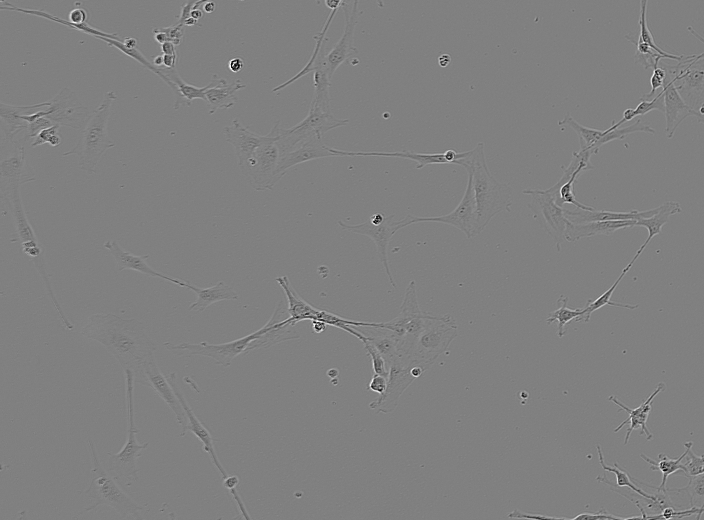

In [41]:
loadfile("/home/justin/projects/CSegKgJ/data/test/d48ec7815252.png")

In [63]:
test_images

mapobs(loadfile, ["../data/test/7ae19de7bc2a.png", "../data/test/d48ec7815252.png", "../data/test…])

In [282]:
ŷs = learner.model(traindl) |> cpu;

LoadError: MethodError: no method matching (::Conv{2, 2, typeof(identity), CUDA.CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CUDA.CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}})(::DataLoaders.BufferGetObsParallel{Tuple{Array{Float32, 4}, Array{Float32, 4}}, DataLoaders.BatchViewCollated{DLPipelines.MethodDataset{BlockMethod{Tuple{Image{2}, Mask{2, String}}, Tuple{ProjectiveTransforms{2}, ImagePreprocessing{FixedPointNumbers.N0f8, 3, ColorTypes.RGB{FixedPointNumbers.N0f8}, Float32}, OneHot{DataType}}, FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}}}}})
[0mClosest candidates are:
[0m  (::Conv)([91m::AbstractArray[39m) at /home/justin/.julia/packages/Flux/BPPNj/src/layers/conv.jl:163

In [283]:
@show summary(getobs(traindl, 1))

LoadError: MethodError: no method matching getobs(::DataLoaders.BufferGetObsParallel{Tuple{Array{Float32, 4}, Array{Float32, 4}}, DataLoaders.BatchViewCollated{DLPipelines.MethodDataset{BlockMethod{Tuple{Image{2}, Mask{2, String}}, Tuple{ProjectiveTransforms{2}, ImagePreprocessing{FixedPointNumbers.N0f8, 3, ColorTypes.RGB{FixedPointNumbers.N0f8}, Float32}, OneHot{DataType}}, FastAI.Bounded{2, FastAI.OneHotTensor{2, String}}}}}}, ::Int64)
[0mClosest candidates are:
[0m  getobs(::Any, ::Any) at /home/justin/.julia/packages/MLDataPattern/KlSmO/src/container.jl:72
[0m  getobs(::Any, ::Any, [91m::LearnBase.ObsDim.Undefined[39m) at /home/justin/.julia/packages/MLDataPattern/KlSmO/src/container.jl:23
[0m  getobs(::Any, ::Any, [91m::Any...[39m; kw...) at /home/justin/.julia/packages/MLDataPattern/KlSmO/src/container.jl:71
[0m  ...

summary(getobs(test_images, 1)) = "520×704 PermutedDimsArray(::Array{Gray{N0f8},2}, (2, 1)) with eltype ColorTypes.Gray{FixedPointNumbers.N0f8}"
summary(encdata) = "520×704×3 Array{Float32, 3}"


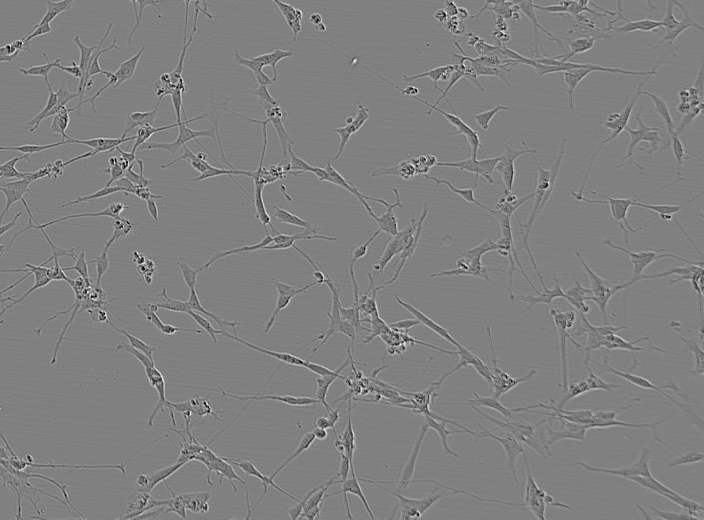

In [155]:
using FastAI
using FastAI: ImageTensor
enc = ImagePreprocessing()
@show summary(getobs(test_images, 1))
encdata = encode(enc, Inference(), Image{2}(), getobs(test_images, 1))
@show summary(encdata)  # (h, w, ch)-image tensor
data_ = decode(enc, Training(), ImageTensor{2}(3), encdata)

In [184]:
model(getobs(test_images, 1:3))

LoadError: DimensionMismatch("Rank of x and w must match! (1 vs. 4)")